In [1]:
import numpy as np
import matplotlib.pyplot as plt
from common import config_tools
import torch, time
from games import GameConfig
from methods.generator import MSGenerator
from methods.ms_conditions import ControllableConditionModel

## Startup Options
Choose the options such as the game, generator, condition model, etc.

In [27]:
game_name = "maze" # The name of game (sokoban, zelda, dave, maze)
generator_path = "./configs/models/ms_gflownet/snake_ms_ce_grux.yml" # The configuration of the generator

experiment_name = "DIV_PR_GFLOW_GRUx" # The name of the experiment if you are using files from the paper experiments
experiment_number = 1 # The number of the experiment if you are using files from the paper experiments
root = f"./experiments/{game_name}/{experiment_name}/{experiment_number}"

weights_path = f"{root}/checkpoints/model_10000.pt" # The generator weights
condition_model_path = f"{root}/condition_models/GMM" # The condition model config and parameters

## Setup
The next few cell create and loads the required objects (game, generator, etc).
You just need to run them in order.

In [28]:
# Create the game
game_config: GameConfig = config_tools.read_config(f"configs/{game_name}/game.yml")
game = game_config.create()

In [29]:
# Load the condition model
condition_model_path = condition_model_path.removesuffix(".cm").removesuffix(".yml")
condition_model_config = config_tools.read_config(condition_model_path + ".yml")
conditions = condition_model_config["conditions"]
cond_model: ControllableConditionModel = condition_model_config["condition_model_config"].model_constructor(game, conditions)
cond_model.load(condition_model_path + ".cm")

In [30]:
# Load the generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator_config = config_tools.read_config(generator_path)
generator: MSGenerator = generator_config.model_constructor(len(game.tiles), len(conditions)).to(device)
weights = torch.load(weights_path, map_location=device)
generator.load_state_dict(weights["netG"])

<All keys matched successfully>

In [31]:
# Load information about the controls
controlled_conditions = config_tools.read_config(f"./configs/{game_name}/analysis/generate_ctrl.yml")["controlled_conditions"]
controlled_conditions = {
    control["control_name"]: {
        "condition": control["condition"], 
        "mapping": eval(f"lambda value, size: {control['mapping']}")
    }
    for control in controlled_conditions
}

def map_controls(controls, size):
    return {
        controlled_conditions[name]["condition"]: controlled_conditions[name]["mapping"](value, size)
        for name, value in controls.items()
    }

In [32]:
# A utility function to present the generation results
def present(results):
    count = len(results)
    levels = np.array([item['level'] for item in results])
    images = game.render(levels, 0)
    images = images.transpose([0, 2, 3, 1])
    r, c = count//5, 5
    fig = plt.figure(figsize=(5*c,5*r))
    axs = fig.subplots(nrows=r, ncols=c, squeeze=False)
    axs = [ax for row in axs for ax in row]
    for i, item in enumerate(results):
        subtitle = "Playable" if item['solvable'] else "Not Playable"
        if item['solvable']:
            for prop in controlled_conditions:
                subtitle += "\n"
                subtitle += f"{prop}: {item[prop]}"
        ax = axs[i]
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(subtitle)

# Generate
- Run the following cell to generate levels.
- You can pick some values for the controls (or leave them empty for unconditonally generate levels).
- You have to pick the requested level size and the requested number of levels. 

Levels generated in 0.6146910190582275 secs
Levels analyzed in 0.017000436782836914 secs


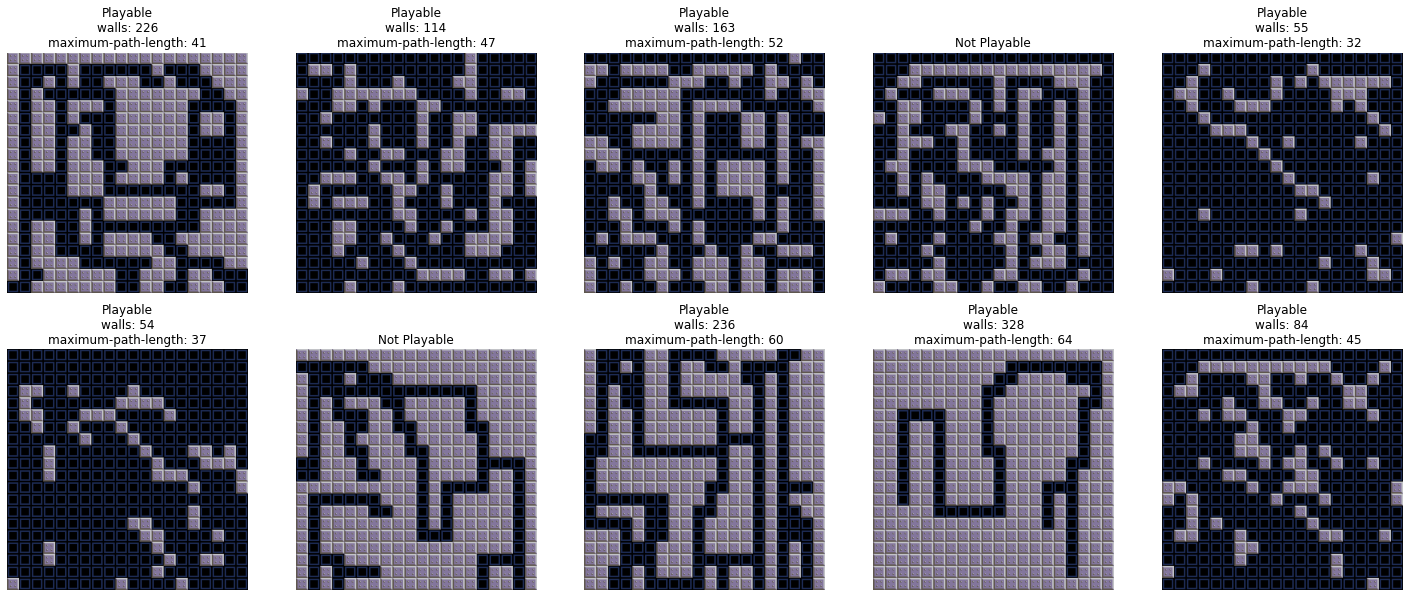

In [40]:
controls = {
    # Sokoban Controls

    # 'pushed-crates': 2,
    # 'solution-length': 300,

    # Zelda Controls

    # 'enemies': 1,
    # 'nearest-enemy-distance': 30,
    # 'path-length': 90,

    # Danger Dave Controls

    # 'spikes': 3,
    # 'jumps': 2,
    # 'solution-length': 50,

    # Maze Controls

    # 'walls': 9000,
    # 'maximum-path-length': 1000,
}
size = (20, 20)
count = 10

# Since the controls are not given to the network (or the condition model) as is,
# we need to map them to their corresponding input values.
given = map_controls(controls, size)

if given:
    query = cond_model.sample_given(size, count, given) # If any controls are picked by the user, we sample the rest conditionally.
else:
    query = cond_model.sample(size, count) # If no controls are picked by the user, all the conditions are sampled unconditionally.

t0 = time.time()
levels = generator.generate(query.to(device), size) # Generate levels using the given conditions at the requested size.
generator_elapsed = time.time() - t0
print(f"Levels generated in {generator_elapsed} secs")

t0 = time.time()
results = game.analyze(levels.tolist()) # Analyze the generation results.
analysis_elapsed = time.time() - t0
print(f"Levels analyzed in {analysis_elapsed} secs")

present(results)